# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

## Instalação das Bibliotecas

In [ ]:
%pip install matplotlib pandas numpy seaborn scikit-learn statsmodels plotly

### Importar Bibliotecas e Bases de Dados

In [3]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

### Consolidação da Base de Dados

Este código combina múltiplos arquivos CSV de dados do Airbnb em um único DataFrame, adicionando informações de mês e ano extraídas dos nomes dos arquivos.

In [ ]:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, "mai": 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

caminho_bases = pathlib.Path('dataset')

base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir(): 
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]

    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))

    df = pd.read_csv(caminho_bases / arquivo.name)
    df['ano'] = ano
    df['mes'] = mes
    base_airbnb = pd.concat([base_airbnb, df])
    df2 = base_airbnb.copy()

display(base_airbnb)

### Tratamentos Dos Dados

- Como temos muitas colunas, nosso modelo pode acabar ficando muito lento.
- Além disso, uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso, vamos excluir algumas colunas da nossa base
- Tipos de colunas que vamos excluir:
    1. IDs, Links e informações não relevantes para o modelo
    2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês)
    3. Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou algo do tipo
    4. Colunas em que todos ou quase todos os valores são iguais
    
- Para isso, vamos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa, olhando as colunas e identificando quais são desnecessárias

In [ ]:
print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

### Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas:

In [ ]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

base_airbnb = base_airbnb.loc[:, colunas]
print(list(base_airbnb.columns))
display(base_airbnb)

### Identificação de Valores Ausentes
Verificamos a quantidade e a proporção de valores ausentes em cada coluna.

In [ ]:
missing_values = base_airbnb.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Valores Ausentes': missing_values,
    'Porcentagem (%)': missing_percent
})

missing_df = missing_df[missing_df['Valores Ausentes'] > 0].sort_values('Porcentagem (%)', ascending=False)
missing_df['Porcentagem (%)'] = missing_df['Porcentagem (%)'].round(2)

print(missing_df)


### Tratamento de Valores Ausentes

- Visualizando os dados, percebemos que existe uma grande disparidade em dados ausentes. As colunas com mais de 300.000 valores NaN foram excluídas da análise
- Para as outras colunas, como temos muitos dados (mais de 900.000 linhas) vamos excluir as linhas que contém dados NaN

In [ ]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
print(base_airbnb.isnull().sum())

### Exclusão de linhas

In [ ]:
base_airbnb = base_airbnb.dropna()

print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

### Verificar Tipos de Dados em cada coluna

- Precisamos fazer isso porque às vezes o Python está lendo como texto alguma coluna que deveria ser um número, então precisamos corrigir

In [ ]:
print(base_airbnb.dtypes)
print('-'*60)
print(base_airbnb.iloc[0])

- Como preço e extra people estão sendo reconhecidos como objeto (ao invés de ser um float) temos que mudar o tipo de variável da coluna.

In [ ]:
#price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)
#extra people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)
#verificando os tipos
print(base_airbnb.dtypes)

### Análise Exploratória e Tratamento de Outliers

- Vamos analisar as features uma por uma para:

  1. Ver a correlação entre as variáveis e decidir se todas serão mantidas no modelo.
  2. Excluir outliers usando a regra: valores abaixo de **Q1 - 1.5 x Amplitude** ou acima de **Q3 + 1.5 x Amplitude** (Amplitude = Q3 - Q1).
  3. Avaliar se cada feature realmente faz sentido no modelo ou se deve ser removida.

- Começaremos pelas colunas **price** (nosso alvo) e **extra_people**, por serem valores numéricos contínuos.

- Em seguida, vamos analisar as colunas com valores numéricos discretos como: `accommodates`, `bedrooms`, `guests_included`, etc.

- Por fim, vamos avaliar as colunas com texto categórico e decidir quais categorias são relevantes para manter no modelo.


In [ ]:
# Select only numeric columns for correlation
numeric_columns = base_airbnb.select_dtypes(include=['number'])

plt.figure(figsize=(15, 10))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='Greens')
plt.show()

### Definição de Funções para Análise de Outliers

Vamos definir algumas funções para ajudar na análise de outliers das colunas

In [ ]:
def limites(coluna):
    """
    Calcula os limites inferior e superior para identificação de outliers usando o método do Intervalo Interquartil (IQR).
    
    Parameters:
        coluna (pandas.Series): Série de dados numéricos para calcular os limites de outliers.
        
    Returns:
        tuple: Um par de valores (limite_inferior, limite_superior) onde:
            - limite_inferior: O valor abaixo do qual os dados são considerados outliers (Q1 - 1.5 * IQR)
            - limite_superior: O valor acima do qual os dados são considerados outliers (Q3 + 1.5 * IQR)
    
    Exemplo:
        >>> import pandas as pd
        >>> dados = pd.Series([1, 2, 3, 4, 5, 20, 30])
        >>> lim_inf, lim_sup = limites(dados)
    """
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude


def excluir_outliers(df, nome_coluna):
    """
    Remove linhas de um DataFrame que contêm outliers em uma coluna específica.
    
    Os outliers são determinados usando o método do Intervalo Interquartil (IQR),
    onde valores fora do intervalo [Q1 - 1.5*IQR, Q3 + 1.5*IQR] são considerados outliers.
    
    Parameters:
        df (pandas.DataFrame): DataFrame a ser filtrado.
        nome_coluna (str): Nome da coluna na qual os outliers serão identificados.
        
    Returns:
        tuple: Um par contendo:
            - pandas.DataFrame: O DataFrame filtrado sem os outliers.
            - int: Número de linhas removidas devido a outliers.
    
    """
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas

In [ ]:
def diagrama_caixa(coluna):
    """
    Cria dois boxplots lado a lado da mesma coluna, o segundo com limites
    ajustados para melhor visualização de outliers.
    
    Parameters:
        coluna (pandas.Series): Série de dados para visualização em boxplot.
    
    Returns:
        None: Exibe o gráfico, mas não retorna valores.
    
    """
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)


def histograma(coluna):
    """
    Cria um histograma com curva de densidade para visualização da distribuição dos dados.
    
    Parameters:
        coluna (pandas.Series): Série de dados para visualização em histograma.
    
    Returns:
        None: Exibe o gráfico, mas não retorna valores.
    
    """
    plt.figure(figsize=(15, 5))
    sns.histplot(coluna, kde=True)


def grafico_barra(coluna):
    """
    Cria um gráfico de barras mostrando a contagem de valores na coluna,
    com os limites do eixo x ajustados para melhor visualização.
    
    Parameters:
        coluna (pandas.Series): Série de dados para visualização em gráfico de barras.
    
    Returns:
        None: Exibe o gráfico, mas não retorna valores.
    
    """
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())

### Visualização de Outliers

### price

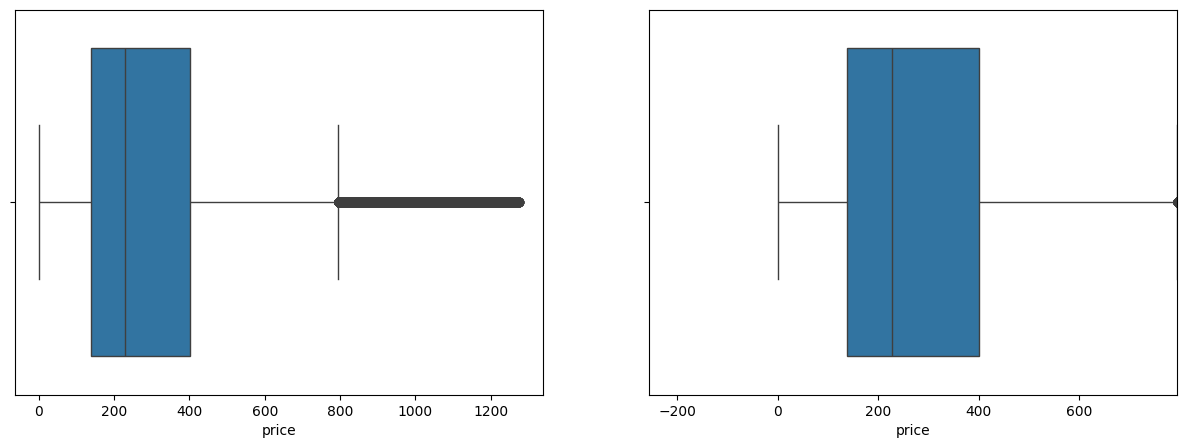

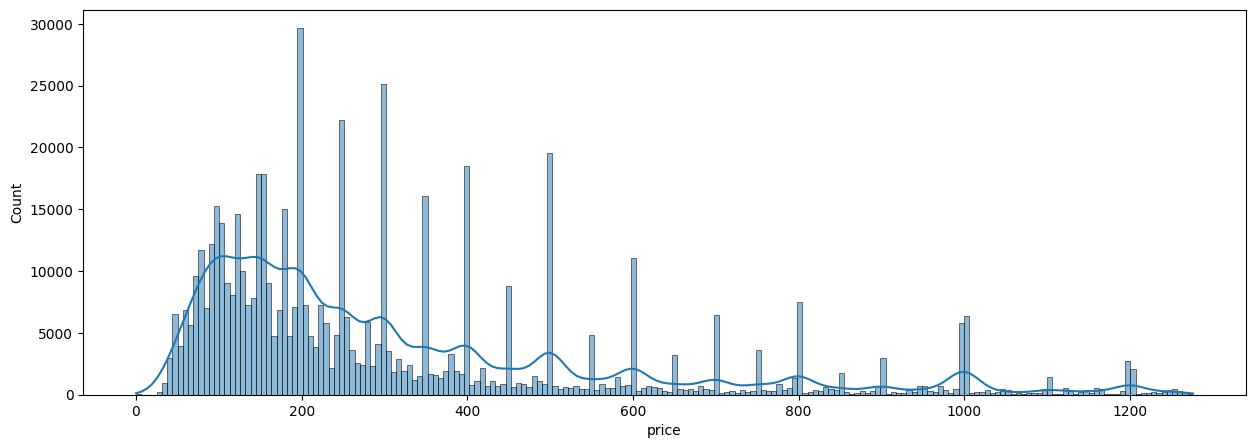

In [49]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas de apartamentos de altíssimo luxo, que não é o nosso objetivo principal. Por isso, podemos excluir esses outliers.

In [22]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


In [ ]:
histograma(base_airbnb['price'])
print(base_airbnb.shape)

### extra_people

In [ ]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [25]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print('{} linhas removidas'.format(linhas_removidas))

59194 linhas removidas


In [ ]:
histograma(base_airbnb['extra_people'])
print(base_airbnb.shape)

### host_listings_count

In [ ]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

Podemos excluir os outliers, porque para o objetivo do nosso projeto, hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [28]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

97723 linhas removidas


### accommodates

In [ ]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

- Pelo mesmo motivo do "host_listings_count" vamos excluir os outliers dessa coluna porque apartamentos que acomodam mais de 9 pessoas não são o nosso foco, nosso objetivo aqui é para imóveis comuns.

- Caso a gente quisesse incluir apartamentos de alto padrão a gente poderia manter essa variável ou então construir um modelo só focado em imóvei com mais de 9 hóspedes

In [30]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

13146 linhas removidas


### bathrooms 

In [ ]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

- Pelo mesmo motivo dos anteriores, vamos excluir os outliers nos banheiros

In [32]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

6894 linhas removidas


### bedrooms

In [ ]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

- Pelo mesmo motivo dos anteriores, vamos excluir outliers em quantidade de quartos

In [34]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))

5482 linhas removidas


### beds

In [ ]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

- Pelo mesmo motivo dos anteriores, vamos excluir outliers em quantidade de camas

In [36]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))

5622 linhas removidas


### guests_included

In [ ]:
diagrama_caixa(base_airbnb['guests_included'])
grafico_barra(base_airbnb['guests_included'])
print(limites(base_airbnb['guests_included']))
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, me parece melhor excluir a coluna da análise

In [38]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

### minimum_nights

In [ ]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

- Aqui temos um motivo talvez até mais forte para excluir esses apartamentos da análise.

- Estamos querendo um modelo que ajude a precificar apartamentos comuns como uma pessoa comum gostaria de disponibilizar. No caso, apartamentos com mais de 8 noites como o "mínimo de noites" podem ser apartamentos de temporada ou ainda apartamentos para morar, em que o host exige pelo menos 1 mês no apartamento.

- Por isso, vamos excluir os outliers dessa coluna

In [40]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{} linhas removidas'.format(linhas_removidas))

40383 linhas removidas


### maximum_nights

In [ ]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

- Essa coluna não parece que vai ajudar na análise.

- Isso porque parece que quase todos os hosts não preenchem esse campo de maximum nights, então ele não parece que vai ser um fator relevante.

- É melhor excluirmos essa coluna da análise

In [42]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581983, 21)

### number_of_reviews   

In [ ]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

- Aqui poderíamos tomar algumas decisões diferentes. Eu vou optar por remover essa característica da análise com base em alguns pontos observados:

  1. Se excluirmos os outliers, vamos acabar removendo os hosts com maior número de reviews — justamente os que mais alugam. Isso pode prejudicar o modelo.
  2. Pensando no objetivo do projeto, se estou colocando meu imóvel agora no Airbnb, é natural que ele não tenha nenhum review ainda. Então remover essa variável pode inclusive ajudar na generalização do modelo.
  3. Tenho dúvidas se essa variável deveria realmente influenciar o preço final, então prefiro não incluí-la nesse momento.

In [44]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)